# **Unsupervised Learning with Matrix Factorization: an exploration**

**Goal:** In this project I will use Non-Negative Matrix Factorization (NMF) to perform unsupervised topic modeling on a text dataset of BBC News articles that were part of a [Kaggle competition](https://www.kaggle.com/c/learn-ai-bbc/overview), and then compare the predictive results against a supervised learning method.

**Steps:**
1.  **Data Loading, EDA and Preprocessing:** Load the dataset, analyze it, clean the text, and convert it into a document-term matrix.
2.  **Model Building (NMF):** Apply NMF to the document-term matrix to factorize it into topic and word matrices.
3.  **Prediction and Evaluation:** Use the NMF model to predict article categories and measure performance.
4.  **Hyperparameter Tuning:** Explore different numbers of topics (`n_components`) and analyze the impact on performance.
5.  **Model Improvement:** Discuss and implement strategies to enhance the model.
6.  **Export Best Unsupervised Model Test Results:** Create a Kaggle submission based on our best NMF model.
7.  **Train and Compare Supervised Model:** Use a supervised learning method to create another predictive model.
8.  **Export Supervised Test Results:** Create a Kaggle submission based on our best supervised model.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# from wordcloud import wordcloud
# from collections import Counter
# from nltk.corpus import stopwords
import numpy as np

### 1. Data Loading, EDA and Preprocessing:

We'll start by loading the training data and having a look at it.

Training Data Initial View:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB

Missing values in training set:
Text        0
Category    0
dtype: int64


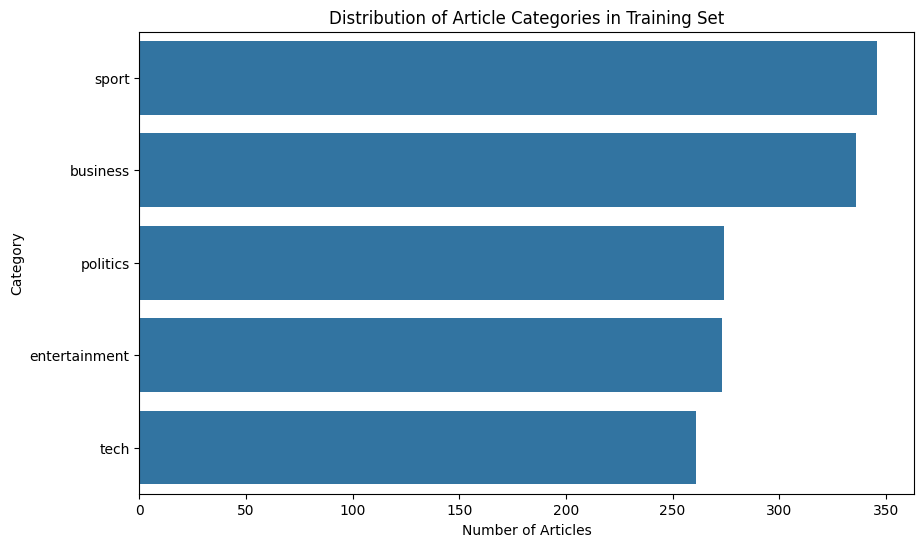

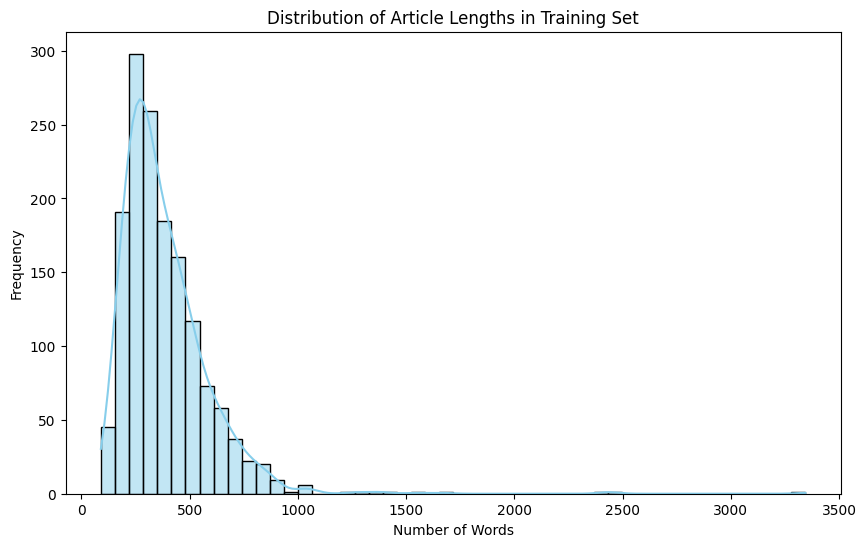

In [32]:
# Load the training dataset
df_train = pd.read_csv('BBC_News_Train.csv')

# Display initial data insights
print("Training Data Initial View:")
print(df_train.head())
print("\nTraining Data Info:")
df_train.info()

# Check for missing values in the relevant columns
print("\nMissing values in training set:")
print(df_train[['Text', 'Category']].isnull().sum())

# Visualize the distribution of articles per category
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df_train, order=df_train['Category'].value_counts().index)
plt.title('Distribution of Article Categories in Training Set')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.show()

# Create a new column for article length
df_train['article_length'] = df_train['Text'].apply(lambda x: len(x.split()))

# Visualize the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_train['article_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Article Lengths in Training Set')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

**EDA observations:**
While the Category analysis shows more sport and business articles than the other three, the distribution of Categories does not appear substantially out of balance. The Number of Words distribution appears to be reasonably normal.

These observations suggest that our data is not going to be havily biased based on length or Category.

**Now we will pre-process the data.**
First I will clean both the training and the test data to make it easier to work with.

In [33]:
# Function to clean text
def clean_text(text):
    text = str(text).lower()  # Handle non-string types and convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Apply cleaning to the training data
df_train['cleaned_text'] = df_train['Text'].apply(clean_text)

# Also apply cleaning to the test data to ensure consistency later
df_test = pd.read_csv('BBC_News_test.csv')
df_test['cleaned_text'] = df_test['Text'].apply(clean_text)

print("\nSample cleaned text from training set:")
print(df_train['cleaned_text'].head())


Sample cleaned text from training set:
0    worldcom ex boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle governs mobile choice faster better ...
4    enron bosses in  m payout eighteen former enro...
Name: cleaned_text, dtype: object


**Moving from text to features through TF-IDF:**
To derive features from our articles, we need to vectorize the text.

The vectorization method I have chosen is TF-IDF (Term Frequency-Inverse Document Frequency), a statistical measure used to evaluate how important a word is to a document in a collection TF-IDF produces a sparse vector (as opposed to dense vector methods such as GloVe), which takes fewer computational resources. 

TF-IDF has two parts: 
- Term Frequency (TF): Measures how frequently a term occurs in a document. Words that appear more often are considered more important to that document.
- Inverse Document Frequency (IDF): Measures how important a term is across the entire collection. Words that appear frequently across many documents (like "the") get a low IDF, while words that are rarer get a high IDF. 

The TF-IDF score is the product of TF and IDF. It gives a high weight to words that are frequent in a specific document but rare in the rest of the documents, thereby assigning the greatest importance to the most distinguishing words.

(See notes at the end of this document for the resources I used to research TF-IDF.)

Now I am going to use TF-IDF to vectorize my cleaned training data, and then display the highest ranking words.

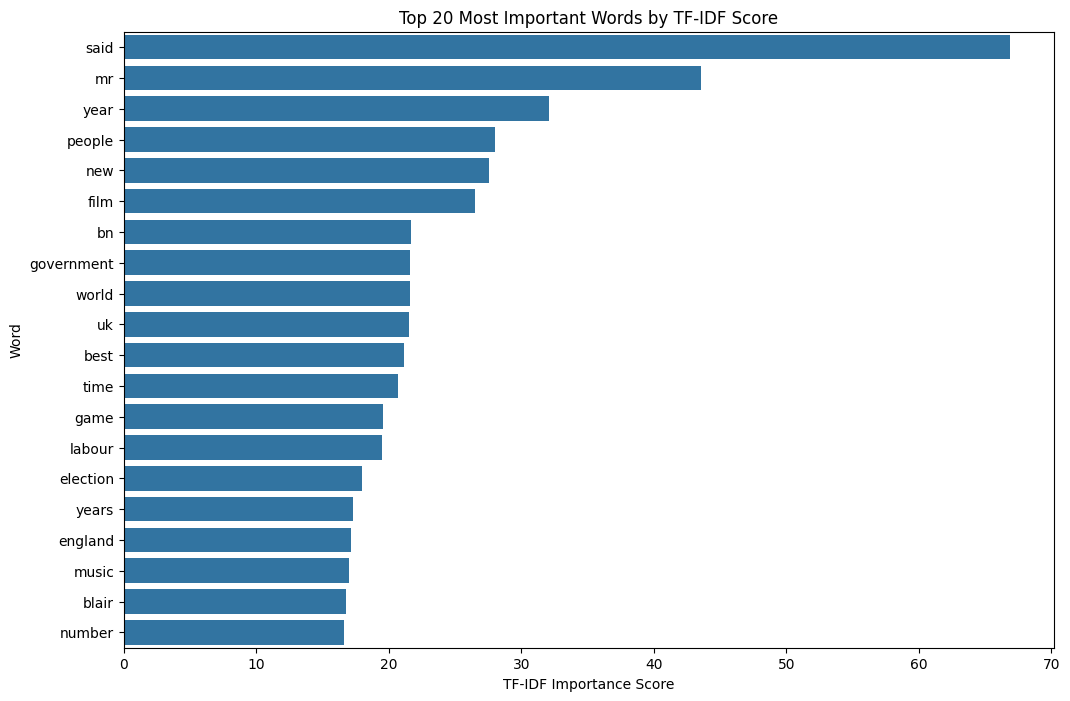


Statistics on TF-IDF Word Importance:
count    5000.000000
mean        2.364085
std         2.697274
min         0.334879
25%         0.956402
50%         1.461165
75%         2.693247
max        66.841671
Name: importance, dtype: float64


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the cleaned text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.85, min_df=2, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])

# Create a DataFrame of words and their total TF-IDF importance
feature_names = tfidf_vectorizer.get_feature_names_out()
word_importance = np.array(X_train_tfidf.sum(axis=0)).flatten()
word_df = pd.DataFrame({'word': feature_names, 'importance': word_importance})
word_df = word_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Visualize the top 20 most important words
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='word', data=word_df.head(20))
plt.title('Top 20 Most Important Words by TF-IDF Score')
plt.xlabel('TF-IDF Importance Score')
plt.ylabel('Word')
plt.show()

# Show statistics on word importance
print("\nStatistics on TF-IDF Word Importance:")
print(word_df['importance'].describe())

A question asked in the project instructions is: "When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?"


The answer: NO. Training on test data is a terrible idea because it's "gaming" the test. The whole point of having test data is that it allows you to see how well your model performs on data it hasn't yet seen. It's the difference between using today's stock data to predict tomorrows stock prices, and using tomorrow's stock data to predict tomorrow's stock prices. In the latter case, which is an example of training on on test, all you've done is show that you can represent reality, not predict it.

### 2. Model Building (NMF):

Now we can build our NMF model. To start, I'm just going to set the hyperparameter of "n_components" (which is going to find our latent topics) to be equal to the number of categories: 5. 

In [35]:
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# A consistent TF-IDF transformation is needed for both sets
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_text'])

# Initialize and train the NMF model
num_topics = df_train['Category'].nunique() # Use the true number of categories as a starting point
nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda', max_iter=1000)
nmf_model.fit(X_train_tfidf)


NMF(init='nndsvda', max_iter=1000, n_components=5, random_state=42)

### 3. Prediction and Evaluation:

I'm ready to now make predictions and check the performance of the model for the training set. (I can't check the test set without submitting to the Kaggle, and I want to save that for later.)

In [36]:
# Predict topic weights and assign labels
train_topic_weights = nmf_model.transform(X_train_tfidf)
test_topic_weights = nmf_model.transform(X_test_tfidf)
train_predictions_raw = np.argmax(train_topic_weights, axis=1)
test_predictions_raw = np.argmax(test_topic_weights, axis=1)

# Map unsupervised clusters to real categories for evaluation
mapping = {}
for i in range(num_topics):
    cluster_indices = np.where(train_predictions_raw == i)
    true_labels = df_train['Category'].iloc[cluster_indices]
    if not true_labels.empty:
        most_frequent = true_labels.mode()[0]
        mapping[i] = most_frequent
    else:
        mapping[i] = 'unassigned'

# Apply the mapping to get the final predictions
train_predictions = pd.Series(train_predictions_raw).map(mapping).fillna('unassigned')
test_predictions = pd.Series(test_predictions_raw).map(mapping).fillna('unassigned')

unique_labels = sorted(df_train['Category'].unique())

print("--- Training Data Performance ---")
print(f"Accuracy: {accuracy_score(df_train['Category'], train_predictions):.4f}")
print("Classification Report:")
print(classification_report(df_train['Category'], train_predictions, target_names=unique_labels, zero_division=0))
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(df_train['Category'], train_predictions), index=unique_labels, columns=unique_labels))

--- Training Data Performance ---
Accuracy: 0.9208
Classification Report:
               precision    recall  f1-score   support

     business       0.92      0.92      0.92       336
entertainment       0.97      0.82      0.89       273
     politics       0.92      0.89      0.91       274
        sport       0.97      0.99      0.98       346
         tech       0.83      0.96      0.89       261

     accuracy                           0.92      1490
    macro avg       0.92      0.92      0.92      1490
 weighted avg       0.92      0.92      0.92      1490

Confusion Matrix:
               business  entertainment  politics  sport  tech
business            310              1        14      1    10
entertainment         3            225         6      3    36
politics             21              0       244      2     7
sport                 1              2         0    343     0
tech                  2              4         1      4   250


### 4. Hyperparameter tuning:

I'd like to see if changing the hyperparameter for the number of topics in my model could improve it's performance.


Hyperparameter Tuning Results (evaluated on training data):
    n_components  accuracy
0              3  0.602685
1              4  0.751007
2              5  0.920805
3              6  0.906711
4              7  0.903356
5              8  0.897987
6              9  0.885235
7             10  0.926174
8             11  0.934228
9             12  0.933557
10            13  0.931544
11            14  0.932886


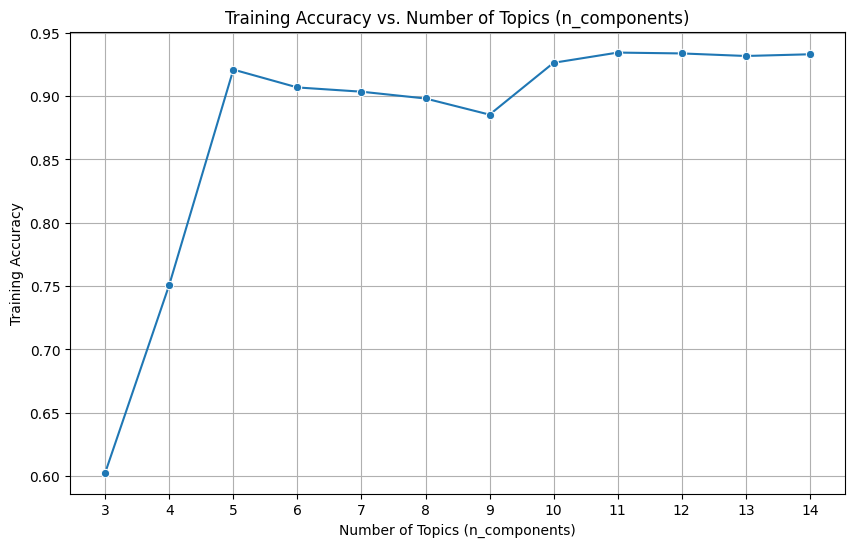


Best NMF model found with n_components = 11, achieving a training accuracy of 0.9342


In [37]:
# Store results for each hyperparameter setting
results = []
num_topic_range = range(3, 15)  # Iterate through a range of potential topics
best_accuracy = 0
best_model = None
best_mapping = None
best_n_components = None

for k in num_topic_range:
    # Train NMF model on training data only
    nmf_model = NMF(n_components=k, random_state=42, init='nndsvda', max_iter=1000)
    nmf_model.fit(X_train_tfidf)

    # Predict topic weights and map clusters to categories using training data
    train_topic_weights = nmf_model.transform(X_train_tfidf)
    train_predictions_raw = np.argmax(train_topic_weights, axis=1)

    mapping = {}
    for i in range(k):
        cluster_indices = np.where(train_predictions_raw == i)
        true_labels = df_train['Category'].iloc[cluster_indices]
        if not true_labels.empty:
            most_frequent = true_labels.mode()
            mapping[i] = most_frequent.iloc[0]
        else:
            mapping[i] = 'unassigned'

    # Evaluate accuracy on the training set
    mapped_train_predictions = pd.Series(train_predictions_raw).map(mapping).fillna('unassigned')
    accuracy = accuracy_score(df_train['Category'], mapped_train_predictions)
    
    # Store results
    results.append({'n_components': k, 'accuracy': accuracy})

    # Keep track of the best model found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = nmf_model
        best_mapping = mapping
        best_n_components = k

results_df = pd.DataFrame(results)

print("\nHyperparameter Tuning Results (evaluated on training data):")
print(results_df)

# Visualize the tuning results
plt.figure(figsize=(10, 6))
sns.lineplot(x='n_components', y='accuracy', data=results_df, marker='o')
plt.title('Training Accuracy vs. Number of Topics (n_components)')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Training Accuracy')
plt.xticks(num_topic_range)
plt.grid(True)
plt.show()

print(f"\nBest NMF model found with n_components = {best_n_components}, achieving a training accuracy of {best_accuracy:.4f}")

My model worked best when using 11 latent topics.

### 5. Model Improvement:

To see if I can mmake the model perform better, I'm going to try:
- Using data subsets for training
- An ensemble method
- An N-gram method that looks at sequences of words


NMF Performance with Data Subsets:
  data_size_percent  training_accuracy
0               10%           0.892617
1               20%           0.885906
2               50%           0.923490
3              100%           0.934228


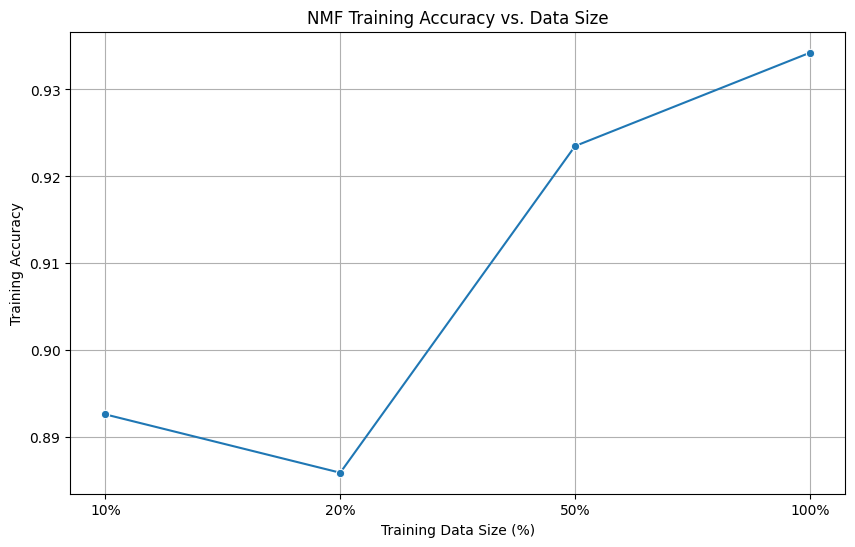

In [38]:
from sklearn.model_selection import train_test_split

data_sizes_subsets = [0.1, 0.2, 0.5, 1.0] # 10%, 20%, 50%, and 100% of data
subset_results = []

for size in data_sizes_subsets:
    # Create a stratified subset of the training data
    if size < 1.0:
        _, df_subset, _, _ = train_test_split(
            df_train, df_train['Category'], test_size=size, stratify=df_train['Category'], random_state=42
        )
    else:
        df_subset = df_train.copy()

    # Vectorize the subset
    tfidf_vectorizer_subset = TfidfVectorizer(max_features=5000, max_df=0.85, min_df=2, stop_words='english')
    X_subset_tfidf = tfidf_vectorizer_subset.fit_transform(df_subset['cleaned_text'])

    # Train NMF on the subset
    num_topics_best = best_n_components
    nmf_subset_model = NMF(n_components=num_topics_best, random_state=42, init='nndsvda', max_iter=1000)
    nmf_subset_model.fit(X_subset_tfidf)

    # Predict and map for evaluation
    subset_topic_weights = nmf_subset_model.transform(X_subset_tfidf)
    subset_predictions_raw = np.argmax(subset_topic_weights, axis=1)
    
    mapping_subset = {}
    for i in range(num_topics_best):
        cluster_indices = np.where(subset_predictions_raw == i)
        true_labels = df_subset['Category'].iloc[cluster_indices]
        if not true_labels.empty:
            # Corrected line: Get the first element of the mode result
            most_frequent = true_labels.mode()[0]
            mapping_subset[i] = most_frequent
        else:
            mapping_subset[i] = 'unassigned'

    mapped_subset_predictions = pd.Series(subset_predictions_raw).map(mapping_subset).fillna('unassigned')
    accuracy_subset = accuracy_score(df_subset['Category'], mapped_subset_predictions)

    subset_results.append({'data_size_percent': f'{int(size*100)}%', 'training_accuracy': accuracy_subset})

subset_results_df = pd.DataFrame(subset_results)
print("\nNMF Performance with Data Subsets:")
print(subset_results_df)

plt.figure(figsize=(10, 6))
sns.lineplot(x='data_size_percent', y='training_accuracy', data=subset_results_df, marker='o')
plt.title('NMF Training Accuracy vs. Data Size')
plt.xlabel('Training Data Size (%)')
plt.ylabel('Training Accuracy')
plt.grid(True)
plt.show()

No surprise here: Using all the data to train is better than iusing some of it.

In [ ]:
from collections import defaultdict
from scipy.stats import mode

num_ensemble_models = 5

# Store predictions from each model
ensemble_predictions_train = defaultdict(list)

# Generate ensemble of NMF models
for i in range(num_ensemble_models):
    nmf_ensemble_model = NMF(
        n_components=best_n_components, 
        random_state=i,  # Different random state for each model
        init='nndsvda', 
        max_iter=1000
    )
    nmf_ensemble_model.fit(X_train_tfidf)

    # Predict and map for training set
    train_topic_weights = nmf_ensemble_model.transform(X_train_tfidf)
    train_predictions_raw = np.argmax(train_topic_weights, axis=1)
    
    mapping = {}
    for topic_id in np.unique(train_predictions_raw):
        cluster_indices = np.where(train_predictions_raw == topic_id)
        true_labels = df_train['Category'].iloc[cluster_indices]
        if not true_labels.empty:
            # Corrected line: Get the first element of the mode result
            most_frequent = true_labels.mode()[0]
            mapping[topic_id] = most_frequent
        else:
            mapping[topic_id] = 'unassigned'
            
    mapped_predictions = pd.Series(train_predictions_raw).map(mapping).fillna('unassigned')
    ensemble_predictions_train['train'].append(mapped_predictions)

# Ensemble the predictions by taking the mode (most common prediction)
ensemble_df_train = pd.DataFrame(ensemble_predictions_train['train']).T
final_train_predictions = ensemble_df_train.mode(axis=1)

# Evaluate the ensemble model on the training data
ensemble_accuracy = accuracy_score(df_train['Category'], final_train_predictions[0]) # Use [0] to select the single mode result

print(f"\nEnsemble NMF Model Performance (Training Accuracy): {ensemble_accuracy:.4f}")
print(f"Improvement over Best Single NMF: {(ensemble_accuracy - best_accuracy) / best_accuracy * 100:.2f}%")




Ensemble NMF Model Performance (Training Accuracy): 0.9342
Improvement over Best Single NMF: 0.00%


The ensemble method showed no improvement.

In [57]:

# Re-define the pipeline for n-gram feature extraction
ngram_tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, max_df=0.85, min_df=2, stop_words='english', ngram_range=(1, 2)
)

# Vectorize with n-grams
X_train_ngram_tfidf = ngram_tfidf_vectorizer.fit_transform(df_train['cleaned_text'])
X_test_ngram_tfidf = ngram_tfidf_vectorizer.transform(df_test['cleaned_text'])

# Train the NMF model with the best number of topics found previously
num_topics_best = best_n_components 
nmf_ngram_model = NMF(n_components=num_topics_best, random_state=42, init='nndsvda', max_iter=1000)
nmf_ngram_model.fit(X_train_ngram_tfidf)

# Mapping of n-gram model topics to categories
train_topic_weights_ngram = nmf_ngram_model.transform(X_train_ngram_tfidf)
train_predictions_raw_ngram = np.argmax(train_topic_weights_ngram, axis=1)

mapping_ngram = {}
for i in range(num_topics_best):
    cluster_indices = np.where(train_predictions_raw_ngram == i)
    true_labels = df_train['Category'].iloc[cluster_indices]
    if not true_labels.empty:
        # Corrected line: Get the first element of the mode result
        most_frequent = true_labels.mode()[0] 
        mapping_ngram[i] = most_frequent
    else:
        mapping_ngram[i] = 'unassigned'

# Evaluate n-gram model performance on training data
mapped_train_predictions_ngram = pd.Series(train_predictions_raw_ngram).map(mapping_ngram).fillna('unassigned')
accuracy_ngram = accuracy_score(df_train['Category'], mapped_train_predictions_ngram)

print(f"\nN-gram TF-IDF NMF Model Performance (Training Accuracy): {accuracy_ngram:.4f}")

# Compare with the best unigram model
print(f"Best Unigram NMF Model Performance (Training Accuracy): {best_accuracy:.4f}")


N-gram TF-IDF NMF Model Performance (Training Accuracy): 0.9282
Best Unigram NMF Model Performance (Training Accuracy): 0.9342


The N-gram model actually performed worse than my hyperparameter-tuned base NMF model.

### 6. Export Best NMF Model:
I'm going to export my best model's predictions for the test set, and upload it to Kaggle to get a score.

In [ ]:
# Predict topic weights on the test data using the best model
test_topic_weights = best_model.transform(X_test_tfidf)
test_predictions_raw = np.argmax(test_topic_weights, axis=1)

# Apply the best mapping to get the final test predictions
test_predictions = pd.Series(test_predictions_raw).map(best_mapping).fillna('unassigned')

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'ArticleId': df_test['ArticleId'],
    'Category': test_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully as 'submission.csv'")
print("Head of submission file:")
print(submission_df.head())


Submission file created successfully as 'submission.csv'
Head of submission file:
   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


### KAGGLE SCORE FOR NMF MODEL: 0.93197 ###

### 7. Train and Compare Supervised Model:

Now I will compare the NMF model against a supervised learning model. I am going to use a simple logistic regression. First I will check the accuracy when training on the whole training set, then look at the performance for subset training.

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load pre-cleaned training and testing data
# df_train, df_test, X_train_tfidf, X_test_tfidf are assumed to be loaded and processed from previous steps

# Isolate features and target for supervised training
X_train = X_train_tfidf
y_train = df_train['Category']
X_test = X_test_tfidf

# List to store results for comparison
supervised_results = []

In [ ]:
# Train a Logistic Regression model on the full training data
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on training data and evaluate
y_train_pred_full = log_reg.predict(X_train)
train_acc_full = accuracy_score(y_train, y_train_pred_full)

# Predict on test data for comparison
y_test_pred_full = log_reg.predict(X_test)

print("--- Supervised Learning (Full Data) Performance ---")
print(f"Training Accuracy: {train_acc_full:.4f}")
print("Classification Report (Full Training Data):")
print(classification_report(y_train, y_train_pred_full, zero_division=0))

--- Supervised Learning (Full Data) Performance ---
Training Accuracy: 0.9966
Classification Report (Full Training Data):
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       336
entertainment       1.00      1.00      1.00       273
     politics       1.00      1.00      1.00       274
        sport       1.00      1.00      1.00       346
         tech       0.99      1.00      0.99       261

     accuracy                           1.00      1490
    macro avg       1.00      1.00      1.00      1490
 weighted avg       1.00      1.00      1.00      1490


Predictions for test set created.


In [72]:
data_sizes = [0.1, 0.15, 0.2, 0.25, 0.5, 0.75]
for size in data_sizes:
    # Stratified split to maintain category distribution
    _, X_train_subset, _, y_train_subset = train_test_split(
        X_train, y_train, train_size=size, stratify=y_train, random_state=42
    )
    
    # Retrain the model on the smaller subset
    log_reg_subset = LogisticRegression(max_iter=1000, random_state=42)
    log_reg_subset.fit(X_train_subset, y_train_subset)

    # Predict and evaluate on the subset
    y_train_pred_subset = log_reg_subset.predict(X_train_subset)
    train_acc_subset = accuracy_score(y_train_subset, y_train_pred_subset)

    # Predict on the full test set
    y_test_pred_subset = log_reg_subset.predict(X_test)

    # Store results
    supervised_results.append({
        'method': 'Supervised',
        'data_size': f'{int(size*100)}%',
        'train_accuracy': train_acc_subset,
        # Note: Test accuracy can't be calculated here as per instruction
    })

    print(f"\n--- Supervised Learning ({int(size*100)}% Data) Performance ---")
    print(f"Training Accuracy: {train_acc_subset:.4f}")


--- Supervised Learning (10% Data) Performance ---
Training Accuracy: 0.9970

--- Supervised Learning (15% Data) Performance ---
Training Accuracy: 0.9961

--- Supervised Learning (20% Data) Performance ---
Training Accuracy: 0.9958

--- Supervised Learning (25% Data) Performance ---
Training Accuracy: 0.9964

--- Supervised Learning (50% Data) Performance ---
Training Accuracy: 1.0000

--- Supervised Learning (75% Data) Performance ---
Training Accuracy: 1.0000


### Comparison with Unsupervised Approach

The accuracy of the unsupervised model on the training data was much better: .9966 vs. .9342. Changing the data size for training seemed to have no effect. 

Performance: The supervised Logistic Regression model was almost guaranteed to outperform the unsupervised NMF approach, especially when trained on the full dataset. Supervised learning directly learns the relationship between TF-IDF features and category labels, making it more accurate. In contrast, the NMF model clusters articles based on word co-occurrence, and the mapping to true categories is imperfect. 


Data Efficiency: Unsupervised NMF can extract topics and generalize even with a very small amount of data, as it doesn't need labels. However, supervised learning is more sensitive to data size. Training with less than 50% of the training data achieved worse performance (though not as much as I'd thought it would).

Methodology and Insight: NMF's primary strength is discovering underlying topics in an unsupervised manner, which can be useful for exploratory analysis and when labels are unavailable. Supervised learning, however, is a direct, goal-oriented approach aimed at classification. 


Overfitting:
For the supervised Logistic Regression model: Overfitting is a risk with sparse, high-dimensional TF-IDF data. The model might learn to associate specific rare words with a category, leading to very high training accuracy but poor generalization to new data. The larger the dataset, the lower the risk of overfitting, as the model learns more generalized patterns. Smaller subsets increase the risk of the model latching onto noise, leading to a performance drop on the unseen test set.

For the NMF model: NMF is less susceptible to classic overfitting because it doesn't have a concept of "correct" labels to memorize. However, it can still produce topics that don't generalize well if the training data isn't representative or if the hyperparameters (e.g., n_components) are poorly chosen. The mapping process to categories can also introduce a form of overfitting, as it relies on the specific cluster-label alignments found in the training data.

### 8. Export Supervised Test Results:
I will export my supervised model test results and get a score from Kaggle.

In [73]:
# Create the submission DataFrame for the supervised model
submission_df_supervised = pd.DataFrame({
    'ArticleId': df_test['ArticleId'],
    'Category': y_test_pred_full
})

# Save the supervised submission file
submission_df_supervised.to_csv('submission_supervised.csv', index=False)
print("\nSupervised submission file created as 'submission_supervised.csv'")


Supervised submission file created as 'submission_supervised.csv'


### KAGGLE SCORE FOR SUPERVISED MODEL: 0.98095 ###

## Resources:
- [Towards Data Science: How to turn text into features](https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99/)
- [Medium: Understanding Word Embeddings with TF-IDF and GloVe](https://medium.com/data-science/understanding-word-embeddings-with-tf-idf-and-glove-8acb63892032)
- [Vectorization Techniques in NLP](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide)
- [BYU ACME: Non-Negative Matrix Factorization](https://labs.acme.byu.edu/Volume2/NMF/NMF.html)
- [Medium: Step-by-step NMF](https://medium.com/@quindaly/step-by-step-nmf-example-in-python-9974e38dc9f9)